In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

<Axes: xlabel='풍속 (m/s)', ylabel='Count'>

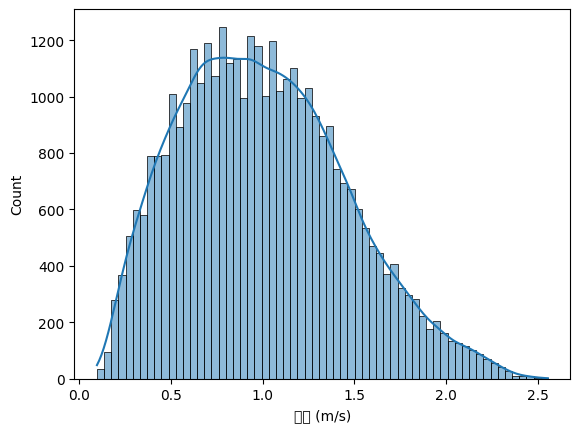

In [ ]:
log = np.log1p(train['풍속 (m/s)'])
sns.histplot(log, kde=True)

In [ ]:
features = train.dtypes[train.dtypes != 'object'].index

skew_features = train[features].apply(lambda x : skew(x))

#skew 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

증기압 부족량(mbar)    2.374898
풍속 (m/s)         1.624866
포화 증기압(mbar)     1.287343
dtype: float64


In [ ]:
train[skew_features_top.index] = np.log1p(train[skew_features_top.index])

In [ ]:
features2 = test.dtypes[test.dtypes != 'object'].index

skew_features2 = test[features2].apply(lambda x : skew(x))

#skew 정도가 1 이상인 칼럼만 추출
skew_features_top2 = skew_features2[skew_features2 > 1]
print(skew_features_top2.sort_values(ascending=False))

증기압 부족량(mbar)    2.280276
포화 증기압(mbar)     1.252155
dtype: float64


In [ ]:
test[skew_features_top2.index] = np.log1p(test[skew_features_top2.index])

#### 모델링 5

- 다른 전처리는 동일, 인코딩만 원핫인코딩으로 바꾼 후 LinearRegression+Ridge+Lasso 혼합 모델

In [ ]:
#원핫인코딩
train = pd.concat([train, pd.get_dummies(train['측정 시간대'])], axis=1)
train = train.drop('측정 시간대', axis=1)
train.head(3)

,ID,월,일,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s),새벽,오전,오후,저녁
0,TRAIN_00000,7,2,13.97,287.78,9.84,76.1,992.08,2.832036,12.16,1.572774,7.66,1198.06,155.6,0.959350,0,0,0,1
1,TRAIN_00001,8,21,16.94,290.85,12.14,73.3,991.07,3.012098,14.17,1.818077,8.94,1183.67,177.0,0.985817,0,1,0,0
2,TRAIN_00002,11,1,9.76,283.84,5.40,74.2,988.71,2.572612,8.98,1.415853,5.67,1213.22,146.2,0.548121,0,0,0,1


In [ ]:
test = pd.concat([test, pd.get_dummies(test['측정 시간대'])], axis=1)
test = test.drop('측정 시간대', axis=1)
test.head(3)

,ID,월,일,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),새벽,오전,오후,저녁
0,TEST_00000,3,24,4.28,278.68,-0.21,72.5,984.48,2.230014,6.02,1.187843,3.81,1233.29,251.80,1,0,0,0
1,TEST_00001,9,24,13.40,286.81,10.36,81.8,996.98,2.797281,12.59,1.335001,7.89,1206.20,225.60,0,0,0,1
2,TEST_00002,5,28,19.89,294.33,14.95,73.2,984.83,3.188829,17.03,1.978239,10.82,1163.06,10.39,0,0,0,1


In [ ]:
X_train_5 = train.drop(['ID', '풍속 (m/s)'], axis=1)
y_train_5 = train['풍속 (m/s)']
X_test = test.drop('ID', axis=1)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_5)
train_scaled = scaler.transform(X_train_5)

In [ ]:
scaler.fit(X_test)
test_scaled = scaler.transform(X_test)

- 릿지와 라쏘의 최적 알파값 찾기

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
  ridge = Ridge(alpha=alpha)

  neg_mse_scores = cross_val_score(ridge, X_train_5, y_train_5, scoring='neg_mean_squared_error', cv=5)
  avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0}일 때, 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때, 5 folds의 평균 RMSE: 0.394
alpha 0.1일 때, 5 folds의 평균 RMSE: 0.394
alpha 1일 때, 5 folds의 평균 RMSE: 0.395
alpha 10일 때, 5 folds의 평균 RMSE: 0.396
alpha 100일 때, 5 folds의 평균 RMSE: 0.397


In [ ]:
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose: print('######', model_name, '######')
  for param in params:
    if model_name =='Ridge': model = Ridge(alpha=param)
    elif model_name =='Lasso': model = Lasso(alpha=param)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5 )
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))

    #모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data_n, y_target_n)
    if return_coeff:
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff

  return coeff_df

In [ ]:
lasso_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas,
                                     X_data_n=X_train_5, y_target_n=y_train_5)

###### Lasso ######
alpha 0.07일 때 5 folds의 평균 RMSE: 0.412
alpha 0.1일 때 5 folds의 평균 RMSE: 0.412
alpha 0.5일 때 5 folds의 평균 RMSE: 0.422
alpha 1일 때 5 folds의 평균 RMSE: 0.429
alpha 3일 때 5 folds의 평균 RMSE: 0.453


릿지 알파는 100, 라쏘 알파는 3

In [ ]:
lr_reg = LinearRegression()
lr_reg.fit(X_train_5, y_train_5)
ridge_reg = Ridge(alpha=100)
ridge_reg.fit(X_train_5, y_train_5)
lasso_reg = Lasso(alpha=3)
lasso_reg.fit(X_train_5, y_train_5)

Lasso(alpha=3)

In [ ]:
lr_pred = lr_reg.predict(X_test)
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred_5 = 0.4 * lr_pred + 0.3 * ridge_pred + 0.3 * lasso_pred
preds_5 = {'최종 혼합': pred_5,
          'LinearRegression': lr_pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

In [ ]:
preds_5

{'최종 혼합': array([1.03860232, 0.84756595, 0.98939609, ..., 0.81281087, 0.95418287,
        0.96454278]),
 'LinearRegression': array([1.0534854 , 0.76902181, 0.98695701, ..., 0.7292667 , 0.94926724,
        0.94704615]),
 'Ridge': array([1.05471236, 0.79720924, 0.97939611, ..., 0.73436578, 0.91227173,
        0.94976622]),
 'Lasso': array([1.00264817, 1.00264817, 1.00264817, ..., 1.00264817, 1.00264817,
        1.00264817])}

In [ ]:
pred_5

array([1.03860232, 0.84756595, 0.98939609, ..., 0.81281087, 0.95418287,
       0.96454278])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_5
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,1.038602
1,TEST_00001,0.847566
2,TEST_00002,0.989396
3,TEST_00003,0.881403
4,TEST_00004,1.068936


In [ ]:
submission.to_csv('submission_5(2).csv', index=  False)

3가지 선형 모델을 혼합한 결과, 점수가 매우 낮게 나옴

이 데이터셋은 선형 모델보다 회귀 트리가 더 잘맞는거같음

→ 이유가 뭘까..

#### 모델링 6

- 릿지 단일모델 예측 결과

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = ridge_pred
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,0.668132
1,TEST_00001,0.140317
2,TEST_00002,-0.415174
3,TEST_00003,0.697225
4,TEST_00004,0.756002


In [ ]:
submission.to_csv('submission_6.csv', index=  False)

릿지, 라쏘, 선형 회귀 3가지를 혼합한 것보다 릿지 단일 모델의 성능이 더 좋게 나옴

#### 모델링 7

- 회귀 트리 모델 5개 블랜딩(DecisionTreeRegressor+RandomForestRegressor+GradientBoostingRegressor+XGBRegressor+LGBMRegressor)

- 트리 모델들 최적 하이퍼 파라미터 찾기

In [ ]:
X_train_6 = X_train_5.copy()
y_train_6 = y_train_5.copy()

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

In [ ]:
dt_model = dt_reg.fit(X_train_6, y_train_6)
rf_model = rf_reg.fit(X_train_6, y_train_6)
gb_model = gb_reg.fit(X_train_6, y_train_6)
xgb_model = xgb_reg.fit(X_train_6, y_train_6)
lgbm_model = lgb_reg.fit(X_train_6, y_train_6)

In [ ]:
def blended_predictions(X):
    return ((0.2 * dt_model.predict(X)) + \
            (0.2 * rf_model.predict(X)) + \
            (0.2 * gb_model.predict(X)) + \
            (0.2 * xgb_model.predict(X)) + \
            (0.2 * lgbm_model.predict(X)))

In [ ]:
pred_7 = blended_predictions(X_test)

In [ ]:
pred_7

array([1.14731489, 0.75232966, 1.0522316 , ..., 0.74765886, 1.15864052,
       0.72316104])

In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_7
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,1.147315
1,TEST_00001,0.752330
2,TEST_00002,1.052232
3,TEST_00003,0.735301
4,TEST_00004,0.834803


In [ ]:
submission.to_csv('submission_7.csv', index=  False)

#### 모델링 8

- AutoML 라이브러리 pycaret 적용

- 별도의 전처리 없이

- https://today-1.tistory.com/17

In [ ]:
train_7 = train.drop('ID', axis=1)
test_7 = test.drop('ID', axis=1)

In [ ]:
!pip install pycaret
!pip install markupsafe==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 34.0 MB/s eta 0:0

In [ ]:
from pycaret.regression import *

setup_reg = setup(train_7, target = '풍속 (m/s)', train_size=0.8)

,Description,Value
0,Session id,7574
1,Target,풍속 (m/s)
2,Target type,Regression
3,Original data shape,"(36581, 15)"
4,Transformed data shape,"(36581, 18)"
5,Transformed train set shape,"(29264, 18)"
6,Transformed test set shape,"(7317, 18)"
7,Numeric features,13
8,Categorical features,1
9,Preprocess,True


In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
best = compare_models(sort = 'RMSE', fold=3, n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4293,0.3421,0.5849,0.8571,0.1998,0.3611,8.8800
rf,Random Forest Regressor,0.4833,0.4337,0.6585,0.8188,0.2248,0.4243,23.5600
xgboost,Extreme Gradient Boosting,0.5644,0.5775,0.7597,0.7588,0.2528,0.4674,3.8133
lightgbm,Light Gradient Boosting Machine,0.6123,0.6572,0.8106,0.7255,0.2689,0.5266,1.3433
knn,K Neighbors Regressor,0.6256,0.7614,0.8725,0.6819,0.2914,0.5705,1.5367
dt,Decision Tree Regressor,0.6330,0.8769,0.9363,0.6336,0.3039,0.4981,0.8467
gbr,Gradient Boosting Regressor,0.7818,1.0776,1.0380,0.5498,0.3280,0.6734,7.3467
lr,Linear Regression,1.0091,1.8303,1.3529,0.2354,0.4079,0.8693,4.5333
br,Bayesian Ridge,1.0090,1.8303,1.3529,0.2354,0.4079,0.8692,0.1833
ridge,Ridge Regression,1.0106,1.8411,1.3569,0.2309,0.4086,0.8705,0.9267


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

상위 모델 5개를 튜닝해서 앙상블하자

In [ ]:
tuned_model = [tune_model(i) for i in best]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6381,0.7162,0.8463,0.6977,0.2755,0.5543
1,0.6514,0.7318,0.8555,0.6934,0.2830,0.5932
2,0.6344,0.6994,0.8363,0.7131,0.2787,0.5805
3,0.6452,0.7442,0.8627,0.6967,0.2772,0.5606
4,0.6326,0.7144,0.8452,0.6987,0.2745,0.5564
5,0.6551,0.7980,0.8933,0.6758,0.2799,0.5489
6,0.6479,0.7088,0.8419,0.6936,0.2805,0.5715
7,0.6570,0.7433,0.8622,0.6896,0.2846,0.5918
8,0.6349,0.6775,0.8231,0.7023,0.2783,0.5754


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6501,0.8014,0.8952,0.6618,0.2885,0.5283
1,0.6705,0.8663,0.9308,0.6370,0.2985,0.5592
2,0.6690,0.8700,0.9328,0.6431,0.3008,0.5701
3,0.6608,0.8453,0.9194,0.6554,0.2974,0.5497
4,0.6453,0.8424,0.9178,0.6447,0.2898,0.5294
5,0.6633,0.8668,0.9310,0.6479,0.2920,0.5229
6,0.6752,0.8596,0.9271,0.6284,0.3014,0.5698
7,0.6654,0.8159,0.9033,0.6593,0.2960,0.5621
8,0.6463,0.7833,0.8851,0.6558,0.2887,0.5300


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5153,0.4797,0.6926,0.7975,0.2316,0.4205
1,0.5287,0.4885,0.6989,0.7953,0.2373,0.4471
2,0.5151,0.4927,0.7019,0.7979,0.2347,0.4337
3,0.5222,0.4871,0.6979,0.8014,0.2352,0.4323
4,0.5120,0.4713,0.6865,0.8013,0.2330,0.4283
5,0.5162,0.4837,0.6955,0.8035,0.2311,0.4131
6,0.5263,0.4832,0.6951,0.7911,0.2373,0.4427
7,0.5279,0.5086,0.7132,0.7876,0.2421,0.4508
8,0.4997,0.4394,0.6629,0.8069,0.2293,0.4175


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5156,0.4721,0.6871,0.8007,0.2351,0.4076
1,0.5093,0.4647,0.6817,0.8053,0.2341,0.4170
2,0.5275,0.5051,0.7107,0.7928,0.2417,0.4280
3,0.5141,0.4790,0.6921,0.8048,0.2371,0.4178
4,0.5189,0.4721,0.6871,0.8009,0.2410,0.4290
5,0.5293,0.4942,0.7030,0.7992,0.2390,0.4205
6,0.5262,0.4827,0.6948,0.7913,0.2420,0.4261
7,0.5260,0.5000,0.7071,0.7912,0.2461,0.4412
8,0.5202,0.4795,0.6925,0.7893,0.2432,0.4341


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5635,0.5874,0.7664,0.7521,0.2616,0.5244
1,0.5639,0.5928,0.7699,0.7516,0.2672,0.5570
2,0.5626,0.5924,0.7697,0.7570,0.2687,0.5526
3,0.5583,0.5888,0.7673,0.7600,0.2626,0.5283
4,0.5484,0.5735,0.7573,0.7581,0.2624,0.5273
5,0.5451,0.5507,0.7421,0.7763,0.2547,0.4952
6,0.5606,0.6026,0.7763,0.7395,0.2673,0.5393
7,0.5712,0.5964,0.7723,0.7509,0.2724,0.5629
8,0.5503,0.5729,0.7569,0.7482,0.2655,0.5353


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model

[ExtraTreesRegressor(n_jobs=-1, random_state=7574),
 RandomForestRegressor(n_jobs=-1, random_state=7574),
 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=70, n_jobs=-1, num_parallel_tree=None, predictor=None,
              random_state=7574, ...),
 LGBMRegressor(bagging_fraction=0.8, bagging_freq=6, feature_fraction=0.6,
               learning_rate=0.5, min_child_samples=71, min_split_gain=0.1,

In [ ]:
blended = blend_models(estimator_list = tuned_model, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4493,0.3619,0.6016,0.8472,0.2063,0.3861
1,0.4505,0.3605,0.6004,0.8490,0.2086,0.4027
2,0.4530,0.3776,0.6145,0.8451,0.2122,0.4040
3,0.4500,0.3686,0.6071,0.8497,0.2076,0.3885
4,0.4405,0.3519,0.5932,0.8516,0.2069,0.3895
5,0.4451,0.3589,0.5990,0.8542,0.2046,0.3754
6,0.4577,0.3646,0.6038,0.8424,0.2125,0.4045
7,0.4605,0.3776,0.6145,0.8423,0.2157,0.4143
8,0.4376,0.3363,0.5799,0.8522,0.2064,0.3894


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
final_model = finalize_model(blended)
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
pred_8 = predict_model(final_model, data=test_7)

In [ ]:
pred_8

,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),prediction_label
0,3,24,새벽,4.280000,278.679993,-0.21,72.500000,984.479980,8.300000,6.020000,2.28,3.81,1233.290039,251.800003,2.189815
1,9,24,저녁,13.400000,286.809998,10.36,81.800003,996.979980,15.400000,12.590000,2.80,7.89,1206.199951,225.600006,1.167815
2,5,28,저녁,19.889999,294.329987,14.95,73.199997,984.830017,23.260000,17.030001,6.23,10.82,1163.060059,10.390000,1.762841
3,1,17,저녁,-2.880000,270.440002,-4.47,88.699997,998.020020,4.940000,4.380000,0.56,2.73,1284.189941,260.200012,1.109038
4,10,22,오후,6.970000,281.179993,4.36,83.400002,987.000000,10.010000,8.350000,1.66,5.28,1223.469971,262.500000,1.297067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15673,3,16,새벽,1.610000,274.670013,-0.49,85.900002,1001.260010,6.860000,5.890000,0.97,3.67,1266.619995,56.180000,4.427049
15674,9,5,오후,18.270000,292.190002,13.35,73.000000,990.979980,21.030001,15.350000,5.68,9.69,1177.630005,265.299988,2.142691
15675,8,8,새벽,16.080000,289.660004,12.25,78.000000,994.969971,18.299999,14.280000,4.03,8.97,1191.839966,189.800003,1.150959
15676,2,4,새벽,3.070000,276.679993,-0.95,74.800003,994.309998,7.620000,5.700000,1.92,3.57,1251.239990,269.700012,1.919313


In [ ]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_8['prediction_label']
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,2.189815
1,TEST_00001,1.167815
2,TEST_00002,1.762841
3,TEST_00003,1.109038
4,TEST_00004,1.297067


In [ ]:
submission.to_csv('submission_8.csv', index=  False)

- 대회 종료 후 제출 한 결과

  - score: public 0.4202901224, private 0.4221584132

  - public 102위

#### 다음 대회 참가 시 보완해야 할 점

1. 피처 중요도를 확인할 수 있는 모델을 활용하여, 높은 중요도를 가지는 변수, 낮은 중요도를 가지는 변수를 따로 골라내기

  → 높은 중요도를 가지는 변수들은 전처리를 신경써서 하고, 낮은 중요도를 가지는 변수들은 제거해가면서 RMSE나 MAE를 체크하여 제거했을 때의 점수가 더 좋게 나오는지 확인

2. Feature engineering 특성 공학 활용해보기, 중요한 변수들을 섞는 방식..

 - https://dacon.io/competitions/official/236126/codeshare/8582?page=1&dtype=recent

 - Feature Extraction → https://dacon.io/competitions/official/236126/codeshare/8630?page=1&dtype=recent

 - Feature Selection → 변수 선택으로 다중공선성 문제를 해결

3. 시간을 줄이고 코드 길이를 줄이기 위해 함수를 만들어서 활용하는 것이 필요함

  → 스케일링 종류를 테스트해보면서 정한다거나 스태킹 모델을 쓸 때라거나

4. AutoML 라이브러리들을 쓸 때도, 파라미터 조정하기 → AutoGluon의 num_stack_levels, time_limit 같은
